# BirdCLEF - Audio PyTorch Tutorial

Following along with this tutorial: https://www.kaggle.com/code/utcarshagrawal/birdclef-audio-pytorch-tutorial

In [49]:
import os
import gc
import ast
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import torchaudio
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import IPython.display as ipd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

from torch.optim import Adam



In [50]:
df = pd.read_csv('data/train_metadata.csv')
df.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename
0,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,afrsil1/XC125458.ogg
1,afrsil1,"['houspa', 'redava', 'zebdov']",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,afrsil1/XC175522.ogg
2,afrsil1,[],"['call', 'song']",16.2901,-16.0321,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/177993,afrsil1/XC177993.ogg
3,afrsil1,[],"['alarm call', 'call']",17.0922,54.2958,Euodice cantans,African Silverbill,Oscar Campbell,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/205893,afrsil1/XC205893.ogg
4,afrsil1,[],['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,3.0,16:30,https://www.xeno-canto.org/207431,afrsil1/XC207431.ogg


### Analyzing Train_Metadata

c:\Users\sonor\miniconda3\envs\pytorch38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


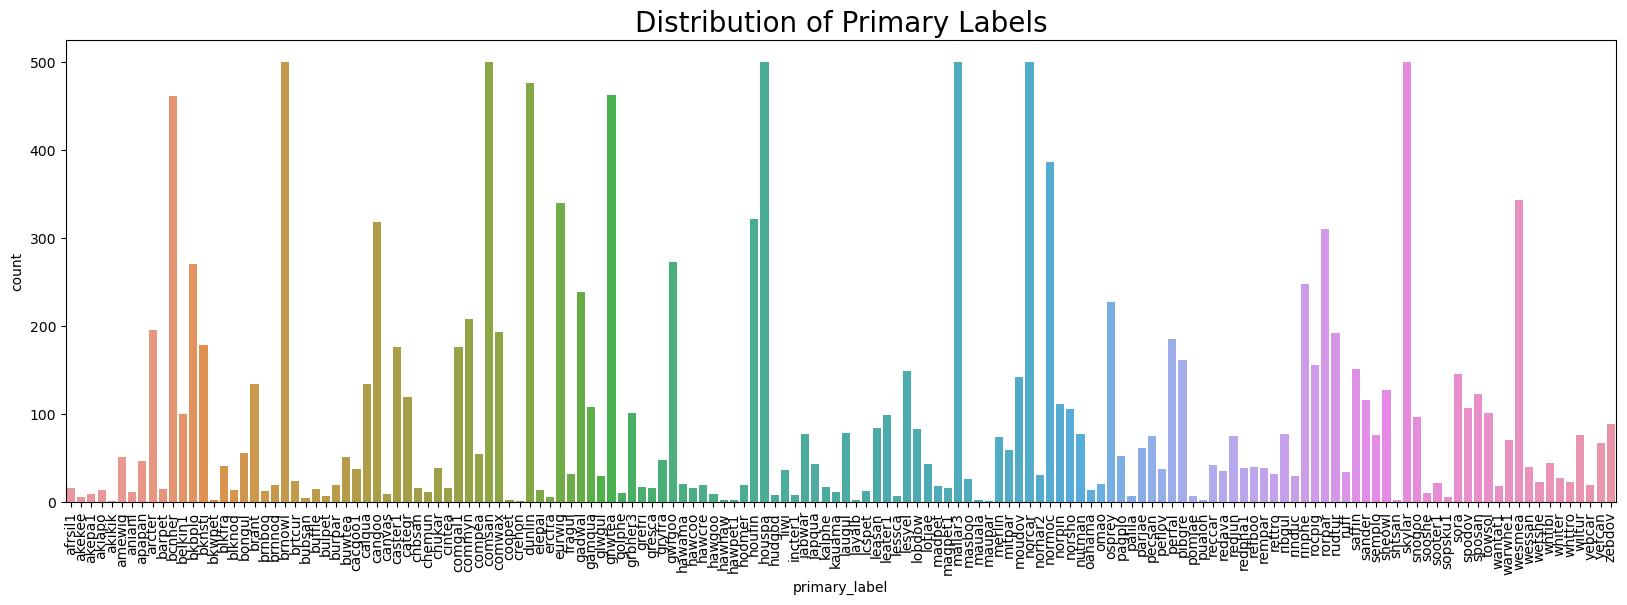

In [51]:
plt.figure(figsize=(20, 6))

sns.countplot(df['primary_label'])
plt.xticks(rotation=90)
plt.title("Distribution of Primary Labels", fontsize=20)

plt.show()


c:\Users\sonor\miniconda3\envs\pytorch38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


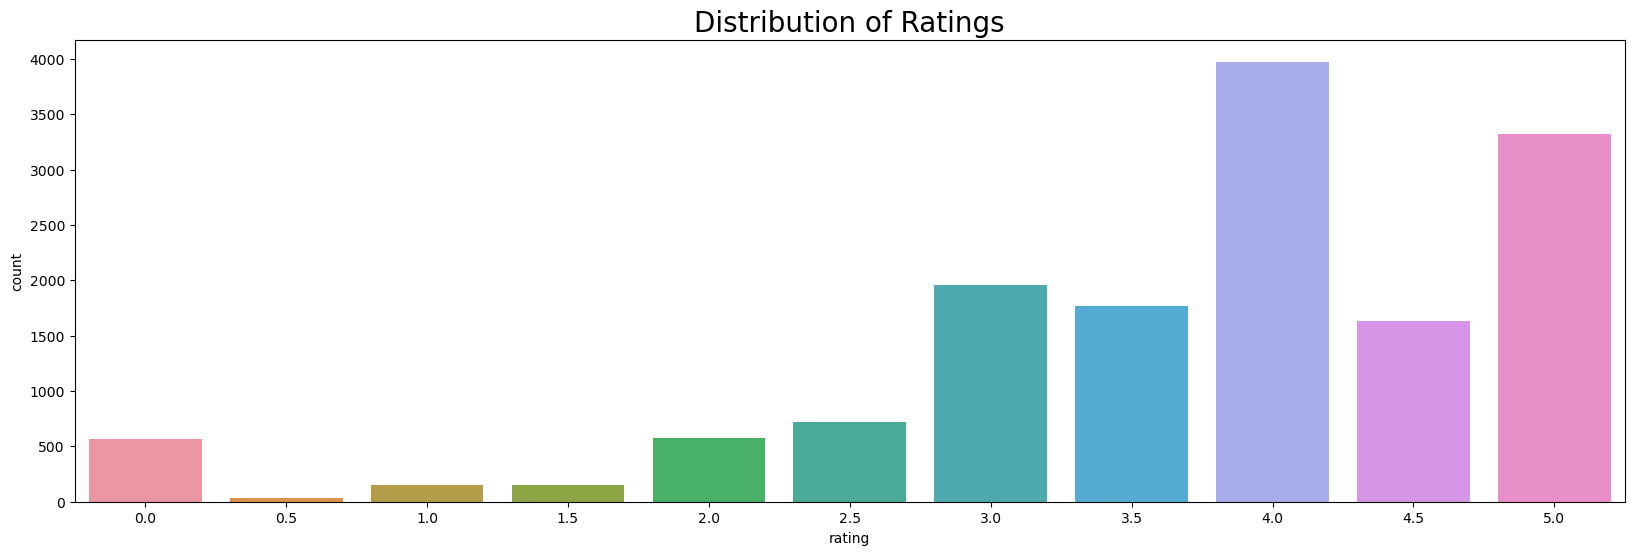

In [52]:
plt.figure(figsize=(20, 6))

sns.countplot(df['rating'])
plt.title("Distribution of Ratings", fontsize=20)

plt.show()

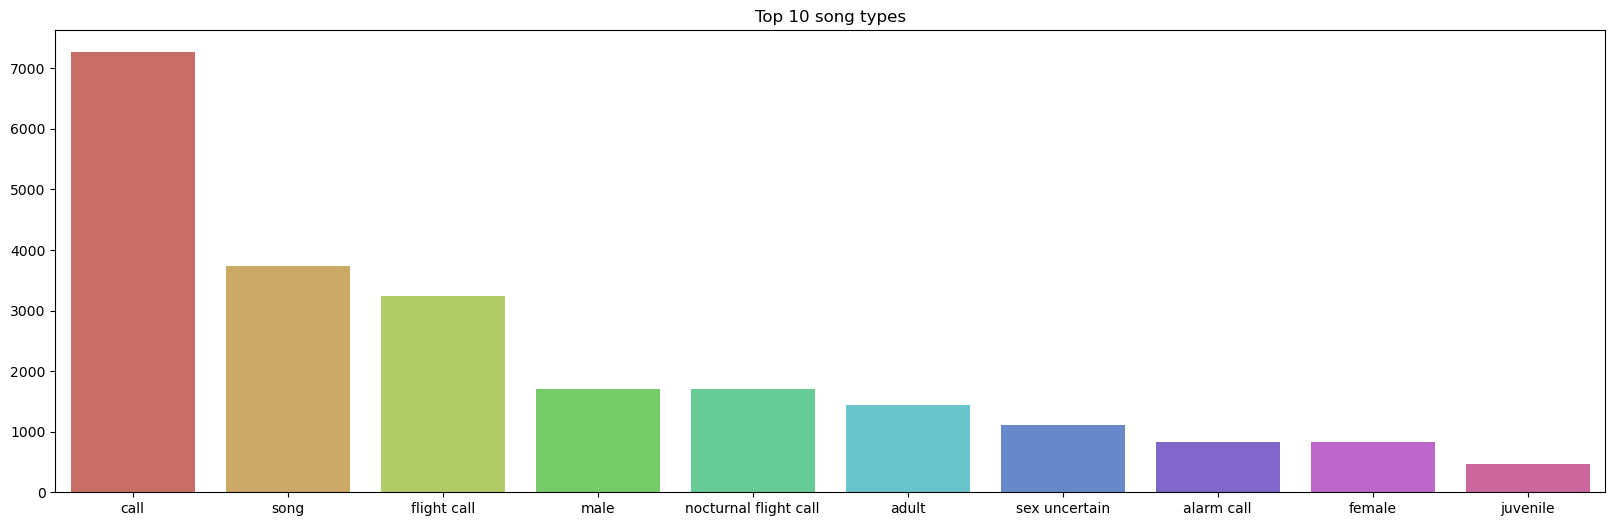

In [53]:
df['type'] = df['type'].apply(lambda x : ast.literal_eval(x))

top = Counter([typ.lower() for lst in df['type'] for typ in lst])

top = dict(top.most_common(10))

plt.figure(figsize=(20, 6))

sns.barplot(x=list(top.keys()), y=list(top.values()), palette='hls')
plt.title("Top 10 song types")

plt.show()

In [54]:
filename_1 = df["filename"].values[0] # first training example
ipd.Audio(f"data/{filename_1}")


In [55]:
filename_2 = df["filename"].values[1]
ipd.Audio(f"data/{filename_2}")

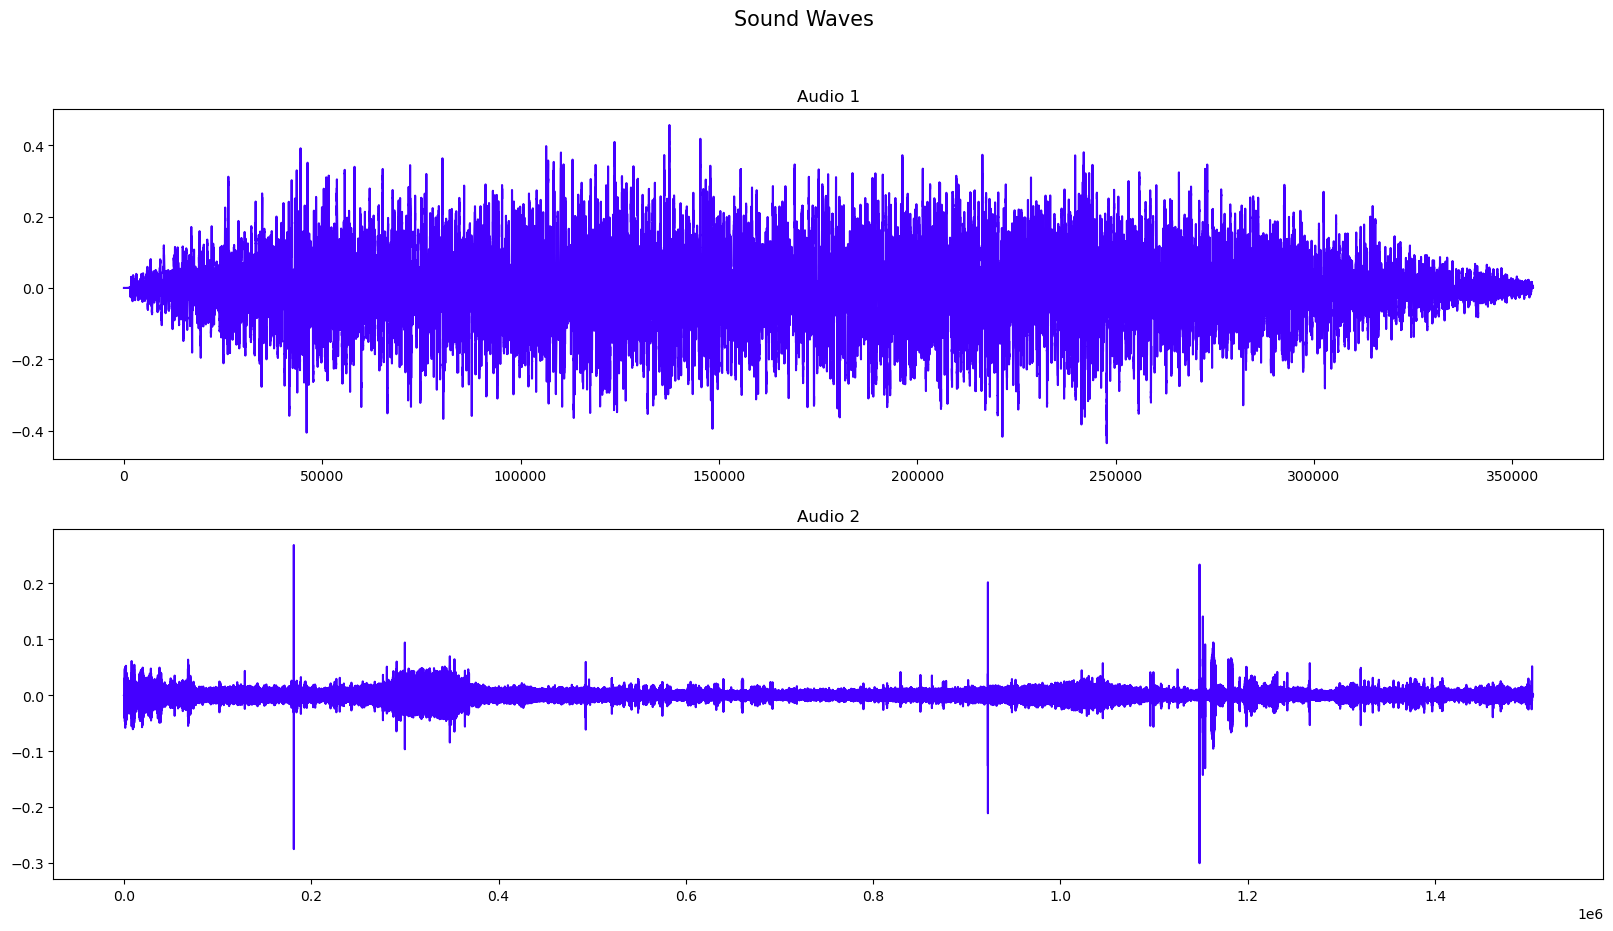

In [56]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
fig.suptitle("Sound Waves", fontsize=15)

signal_1, sr = torchaudio.load(f"data/{filename_1}")
sns.lineplot(x=np.arange(len(signal_1[0, :].detach().numpy())), y=signal_1[0, :].detach().numpy(), ax=ax[0], color='#4400FF')
ax[0].set_title("Audio 1")

signal_2, sr = torchaudio.load(f"data/{filename_2}")
sns.lineplot(x=np.arange(len(signal_2[0, :].detach().numpy())), y=signal_2[0, :].detach().numpy(), ax=ax[1], color='#4400FF')
ax[1].set_title("Audio 2")

plt.show()

## Dataset Preprocessing

In [57]:
class config:
    seed=2022
    num_fold = 5
    sample_rate= 32_000
    n_fft=1024
    hop_length=512
    n_mels=64
    duration=7
    num_classes = 152
    train_batch_size = 32
    valid_batch_size = 64
    model_name = 'resnet50'
    epochs = 2
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    learning_rate = 1e-4

In [58]:
encoder = LabelEncoder() # This is so we can get our outputs from a string format to an integer
df['primary_label_encoded'] = encoder.fit_transform(df['primary_label'])
df.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename,primary_label_encoded
0,afrsil1,[],"[call, flight call]",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,afrsil1/XC125458.ogg,0
1,afrsil1,"['houspa', 'redava', 'zebdov']",[call],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,afrsil1/XC175522.ogg,0
2,afrsil1,[],"[call, song]",16.2901,-16.0321,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/177993,afrsil1/XC177993.ogg,0
3,afrsil1,[],"[alarm call, call]",17.0922,54.2958,Euodice cantans,African Silverbill,Oscar Campbell,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/205893,afrsil1/XC205893.ogg,0
4,afrsil1,[],[flight call],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,3.0,16:30,https://www.xeno-canto.org/207431,afrsil1/XC207431.ogg,0


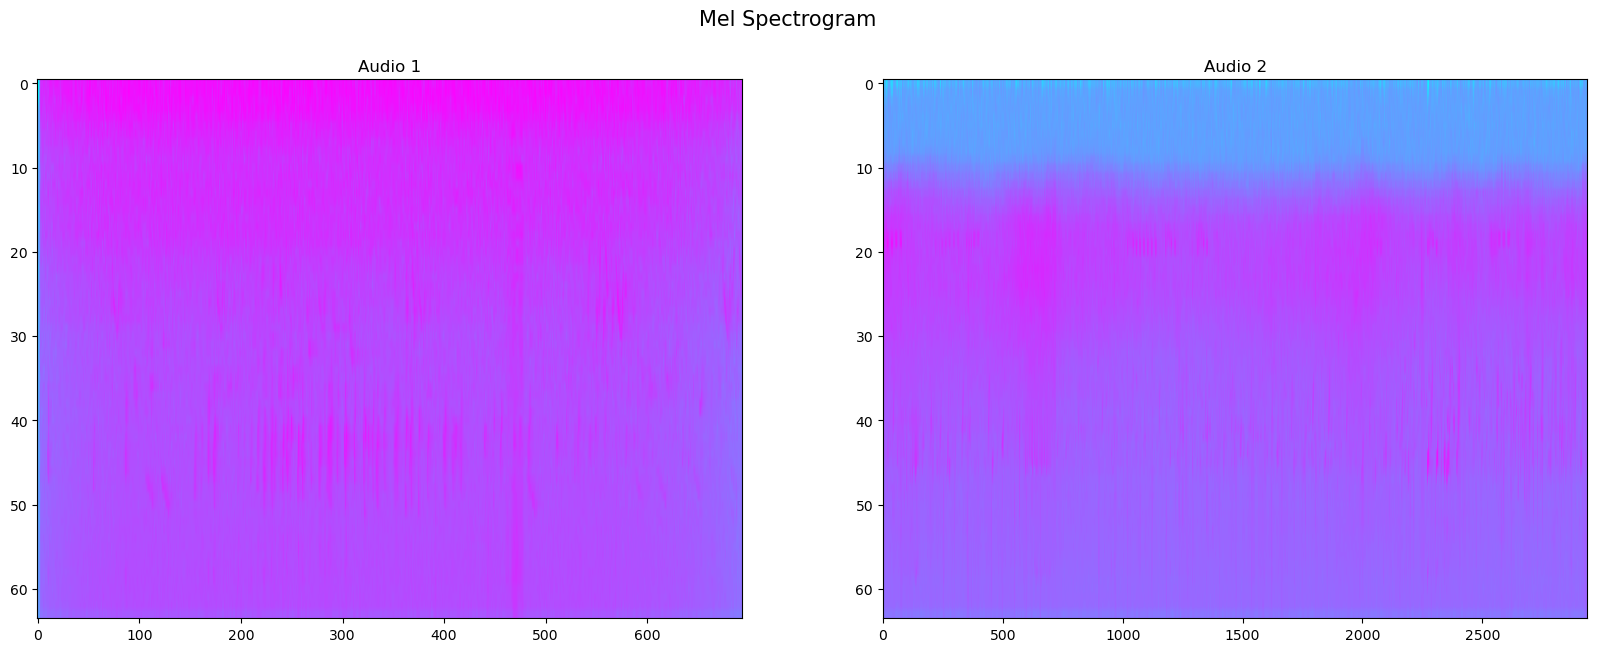

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle("Mel Spectrogram", fontsize=15)

mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=config.sample_rate, 
                                                      n_fft=config.n_fft, 
                                                      hop_length=config.hop_length, 
                                                      n_mels=config.n_mels)

mel_1 = mel_spectrogram(signal_1)
ax[0].imshow(mel_1.log2()[0,:,:].detach().numpy(), aspect='auto', cmap='cool')
ax[0].set_title("Audio 1")

mel_2 = mel_spectrogram(signal_2)
ax[1].imshow(mel_2.log2()[0,:,:].detach().numpy(), aspect='auto', cmap='cool')
ax[1].set_title("Audio 2")

plt.show()

We then must apply a few transformations to our data to even them out.
1) We must resample all of our data to make sure everything has a sample rate and sound
2) Must ensure all audio samples are mono channel
3) Differente in time durations are bad so we must apply padding if less than desired samples or truncate if more than desired samples

In [60]:
class BirdClefDataset(Dataset):
    def __init__(self, df, transformation, target_sample_rate, duration):
        self.audio_paths = df['filename'].values
        self.labels = df['primary_label_encoded'].values
        self.transformation = transformation
        self.target_sample_rate = target_sample_rate
        self.num_samples = target_sample_rate * duration
    
    def __len__(self):
        return len(self.audio_paths)
    
    def __getitem__(self, index):
        audio_path = f"data/{self.audio_paths[index]}"
        signal, sr = torchaudio.load(audio_path)

        # Check if our sample rate is the same as the target sameple rate. If not, resample
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        
        # Check shape and verify it is correct
        if signal.shape[0] > 1:
            signal = torch.mean(signal, axis=0, keepdim=True)
        
        # Check the number of samples and pad/truncate as needed
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        
        elif signal.shape[1] < self.num_samples:
            num_missing_samples = self.num_samples - signal.shape[1]
            last_dim_padding = (0, num_missing_samples)
            signal = F.pad(signal, last_dim_padding)
        
        # Then we can do signal processing. This tutorial uses the Mel Spectrogram, so I will leave that in for right now. This may not be what we want to go with in the end
        mel = self.transformation(signal)

        # Transforms mel into a 3 channel image (This is for CNNs)
        image = torch.cat([mel, mel, mel])

        # Normalize the image
        max_val = torch.abs(image).max()
        image = image / max_val

        label = torch.tensor(self.labels[index])

        return image, label



In [61]:
# This splits the data correctly
skf = StratifiedKFold(n_splits=config.num_fold)
for k, (_, val_ind) in enumerate(skf.split(X=df, y=df['primary_label_encoded'])):
    df.loc[val_ind, 'fold'] = k

c:\Users\sonor\miniconda3\envs\pytorch38\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [62]:
def get_data(fold):
    train_df = df[df['fold'] != fold].reset_index(drop = True)
    valid_df = df[df['fold'] == fold].reset_index(drop = True)

    train_dataset = BirdClefDataset(train_df, mel_spectrogram, config.sample_rate, config.duration)
    valid_dataset = BirdClefDataset(valid_df, mel_spectrogram, config.sample_rate, config.duration)

    train_loader = DataLoader(train_dataset, batch_size=config.train_batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=config.valid_batch_size, shuffle=False)
    
    return train_loader, valid_loader

In [72]:
# Custom Bird Clef Model
class BirdClefModel(nn.Module):
    def __init__(self):
        super(BirdClefModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128*8*54, 64)
        self.fc2 = nn.Linear(64, config.num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [90]:
class BirdCLEFResnet(nn.Module):
    def __init__(self):
        super(BirdCLEFResnet, self).__init__()
        self.base_model = models.__getattribute__(config.model_name)(pretrained=True)
        for param in self.base_model.parameters():
            param.requires_grad = False
            
        in_features = self.base_model.fc.in_features
        
        self.base_model.fc = nn.Sequential(
            nn.Linear(in_features, 1024), 
            nn.ReLU(), 
            nn.Dropout(p=0.2),
            nn.Linear(1024, 512), 
            nn.ReLU(), 
            nn.Dropout(p=0.2),
            nn.Linear(512, config.num_classes))
        
    def forward(self, x):
        x = self.base_model(x)
        return x

In [96]:
def loss_fn(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

def train(model, data_loader, optimizer, scheduler, device, epoch):
    model.train()

    running_loss = 0
    loop = tqdm(data_loader, position=0)
    for i, (mels, labels) in enumerate(loop):
        labels = labels.type(torch.LongTensor)
        mels = mels.to(device)
        labels = labels.to(device)

        outputs = model(mels)
        _, preds = torch.max(outputs, 1)

        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if scheduler is not None:
            scheduler.step()
        
        running_loss += loss.item()

        loop.set_description(f"Epoch [{epoch + 1}/{config.epochs}]")
        loop.set_postfix(loss=loss.item())
    
    return running_loss/len(data_loader)

In [85]:
def valid(model, data_loader, device, epoch):
    model.eval()
    
    running_loss = 0
    pred = []
    label = []
    
    loop = tqdm(data_loader, position=0)
    for mels, labels in loop:
        labels = labels.type(torch.LongTensor)
        mels = mels.to(device)
        labels = labels.to(device)
        
        outputs = model(mels)
        _, preds = torch.max(outputs, 1)
        
        loss = loss_fn(outputs, labels)
            
        running_loss += loss.item()
        
        pred.extend(preds.view(-1).cpu().detach().numpy())
        label.extend(labels.view(-1).cpu().detach().numpy())
        
        loop.set_description(f"Epoch [{epoch+1}/{config.epochs}]")
        loop.set_postfix(loss=loss.item())
        
    valid_f1 = f1_score(label, pred, average='macro')
    
    return running_loss/len(data_loader), valid_f1

In [97]:
def run(fold):
    train_loader, valid_loader = get_data(fold)
    
    # model = BirdClefModel().to(config.device) # check version 3 for this
    model = BirdCLEFResnet().to(config.device)

    optimizer = Adam(model.parameters(), lr=config.learning_rate)
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1e-5, T_max=10)
    
    best_valid_f1 = 0
    for epoch in range(config.epochs):
        train_loss = train(model, train_loader, optimizer, scheduler, config.device, epoch)
        valid_loss, valid_f1 = valid(model, valid_loader, config.device, epoch)
        if valid_f1 > best_valid_f1:
            print(f"Validation F1 Improved - {best_valid_f1} ---> {valid_f1}")
            torch.save(model.state_dict(), f'./model_{fold}.bin')
            print(f"Saved model checkpoint at ./model_{fold}.bin")
            best_valid_f1 = valid_f1
            
    return best_valid_f1

In [98]:
for fold in range(config.num_fold):
    print("=" * 30)
    print("Training Fold - ", fold)
    print("=" * 30)
    best_valid_f1 = run(fold)
    print(f'Best F1 Score: {best_valid_f1:.5f}')
    
    gc.collect()
    torch.cuda.empty_cache()    
     # To run for all the folds, just remove this break

Training Fold -  0


Epoch [1/2]: 100%|██████████| 47/47 [02:27<00:00,  3.15s/it, loss=5.38]


Validation F1 Improved - 0 ---> 0.009848954770385063
Saved model checkpoint at ./model_0.bin


Epoch [2/2:  28%|██▊       | 105/372 [03:04<07:58,  1.79s/it, loss=4.14]